<a href="https://colab.research.google.com/github/jardel-alves0314/analise-de-dados-puc-2023/blob/main/mvp2/notebook/mvp_sprint_2_parte_b_visao_computacional_jardel_dos_anjos_alves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sprint II: Machine Learning & Analytics**
##**Profs:**
##  Patrick Happ
##  Hugo Villamizar

##**Aluno:** Jardel dos Anjos Alves

#**TÍTULO: Deep Learning - Visão Copmputacional**
##**Análise de imagens de RAIO-X para o diagnóstico de pneumonias**


##1.**Definição**

A partir de uma série de radiografias infantis determinar o diagnóstico: NORMAL ou PNEUMONIA.

As radiografias foram disponibilizadas no [Kagle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

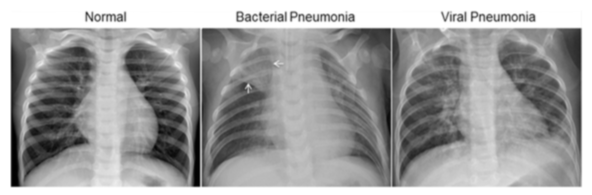

O objetivo é aplicar técnicas de aprendizado de máquina para determinar o diagnóstico através da análise das imagens.


Créditos:

[PAUL MOONEY / Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

[CELL](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)



###**1.1 Fonte dos dados**

Os dados desse projeto são imagens de raio-x, que foram disponibilizadas num arquivo comapactado.

Esses arquivos foram descompactados e disponibilizados na plataforma de github:

https://github.com/jardel-alves0314/analise-de-dados-puc-2023/tree/main/mvp_sprint_2/data/chest_xray




As imagens foram previamente classificadas em: **NORMAL** e **PNEUMONIA**.




A estrutura de diretórios determina a classe da imagem:


  chest_xray / train / NORMAL

  chest_xray / train / PNEUMONIA

  chest_xray / val / NORMAL

  chest_xray / val / PNEUMONIA



##**2.Bibliotecas**

###**2.1 Importando bibliotecas de terceiros**

###Instalando bibliotecas necessárias

In [1]:
!pip install opencv-python

###Importando bibliotecas

In [2]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import sys
import os
from io import BytesIO
import shutil
import random
import math
import numpy as np
import zipfile
from datetime import datetime
import itertools
from IPython.display import display

from abc import ABC, abstractmethod
import array
import traceback

import cv2
import urllib.request
from PIL import Image

import requests

import pandas as pd
import numpy  as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
from sklearn.inspection import permutation_importance

###**2.2 Métodos e Funções**

####**remover_diretorio**

Remove os diretórios temporários dentro do google coolab.

In [3]:
def remover_diretorio(diretorio):
  try:
    shutil.rmtree(f"/content/{destino}")
  except:
    pass

####**exibir_imagem**

Exibe uma imagem.

In [4]:
def exibir_imagem(imagem, titulo, altura, largura):
  print(type(imagem))

  fig, ax = plt.subplots()
  fig.set_size_inches(altura, largura)

  # Exibir a imagem
  ax.imshow(imagem)
  ax.axis('off')

  # Ajustar o tamanho e espaçamento do subplot
  fig.tight_layout()

  # Exibir a figura com a imagem
  plt.title(titulo)
  plt.show()

####**exibir_imagem_do_diretorio**

Exibe uma imagem residente numa pasta.

In [5]:
def exibir_imagem_do_diretorio(caminho, titulo, altura, largura):

  imagem = Image.open(caminho)

  exibir_imagem(imagem, titulo, altura, largura)

####**orthogonal_rot**

Faz a rotação aleatória de 90° de uma imagem. Essa função é usada em conjunto com um ImageDataGenarator.

In [6]:
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))



####**plot_confusion_matrix**

Exibe uma função de confusão, para a análise dos valores reais e preditos de uma classe.

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if i^j and cm[i, j] >= 0 else "white",
                 )

    plt.tight_layout()
    plt.ylabel('REAL')
    plt.xlabel('PREDITO')
    # Mostra o gráfico
    plt.show()

####**baixar_arquivos_retornar_dataframe**

Recebe a url do diretório onde as imagens estão hospedadas, faz o download para o ambiente do google colab e gera um dataframe Pandas.


    **Parâmetros**:

    urls_imagens - url onde as imagens estão hospedads

    tipo - extensão que identifica o tipo da imagem

    destino - destino da imagem dentro do ambiente google colab

    classe - determina a classe das imagens hospedadas na url

    limite - opcional, se for maior que zero fará o download das imagens até a quantidade informada



    **Saída:**

    dataframe com as seguintes informações:

    imagem - nome da imagem

    classe - classe da imagem

    altura - altura da imagem

    largura - largura da imagem

    canais - a quantidade de canais da imagem

    tamanho - tamanho original da imagem

    caminho - caminho no google colab da imagem

    urls - url original da imagem




In [8]:
def baixar_arquivos_retornar_dataframe(urls_imagens, tipo, destino, classe, limite = -1):
  # id       = index

  imagens  = []
  caminhos = []
  tamanhos = []
  alturas  = []
  larguras = []
  canais   = []
  classes  = []
  urls     = []

  contador_ok    = 0
  contador_erro  = 0

  # Criar a estrutura de diretórios, se não existir
  os.makedirs(destino, exist_ok=True)

  for url in urls_imagens:
    print(url)
    response = requests.get(f"{url.strip()}")
    contador = 0


    if response.status_code == 200:
      json = response.json()

      for item in json:
        if not item['name'].strip().endswith(tipo):
          continue

        if limite > 0 and contador >= limite:
          break

        contador += 1

        arquivo = item['name']
        download_url = item['download_url']
        subdiretorio = os.path.dirname(item['path'])



        # Fazer o download do arquivo
        response = requests.get(download_url)
        if response.status_code == 200:

          # arquivo_local = f"imagem_{id}_{classe}.{tipo}"
          arquivo_local = arquivo

          # # Salvar o arquivo no diretório de destino
          # with open(f"{destino}/{arquivo_local}", 'wb') as f:
          #   f.write(response.content)

          try:
            imagem = Image.open(BytesIO(response.content)).convert('L')

            imagem.save(f"{destino}/{arquivo_local}")

            contador_ok += 1
          except:
            contador_erro += 1
            print(f"Não foi possível salvar o arquivo: {arquivo_local} ({download_url})")
            continue

          shape = mpimg.imread(f"{destino}/{arquivo_local}").shape

          imagens.append(arquivo_local)

          caminhos.append(destino)

          tamanhos.append(os.path.getsize(f"{destino}/{arquivo_local}"))

          alturas.append(shape[0])

          larguras.append(shape[1])

          if len(shape) == 3:
            canais.append(shape[2])
          else:
            canais.append(1)

          urls.append(download_url)
          classes.append(classe)

          if contador_ok == 1:
            print(f"download: {download_url}")
            exibir_imagem_do_diretorio(f"{destino}/{arquivo_local}", f"amostra/original: {destino}/{arquivo_local}", 3, 4)
            print(" ")

      print(f"total de aquivos baixados de {url}: {contador}")

  df = pd.DataFrame(columns = ['imagem',
                               'classe',
                               'altura',
                               'largura',
                               'canais',
                               'tamanho',
                               'caminho',
                               'urls'])
  df['imagem']  = imagens
  df['classe']  = classes
  df['altura']  = alturas
  df['largura'] = larguras
  df['canais']  = canais
  df['tamanho'] = tamanhos
  df['caminho'] = caminhos
  df['urls']    = urls

  print("")

  print(f"Total de arquivos baixados: {contador_ok}")
  print(f"Total de arquivos com falha: {contador_erro}")

  print(" ")
  return df


##**3.Processamento**

###**3.1.Pré-Procesamento**


####**3.1.1.Carga das imagens e pré-processamento**

Nessa etapa, são carregadas as imagens do github no google colab. Essa imagens ficam hospedades temporariamente, enquanto durar a sessão do usuário logado.


O resultado final é a geração de dois dataframes:

**df_treino_teste** - desse dataframe serão gerados os dados de TREINO, TESTE e VALIDAÇÃO que serão usados pelo modelo.

**df_validacao** - esse dataframe contém uma quantidade mínima para ser usado no final, já com o modelo salvo.



observação: durante o processo, algumas imagens serão exibidas, caso elas estejam meio esverdeadas, pode ser que a causa seja a distorção de se forçar um tamanho fixo ou a resolução do monitor.

https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/train/NORMAL/
download: https://raw.githubusercontent.com/jardel-alves0314/analise-de-dados-puc-2023/main/mvp_sprint_2/data/chest_xray/train/NORMAL/IM-0001-0001.jpeg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


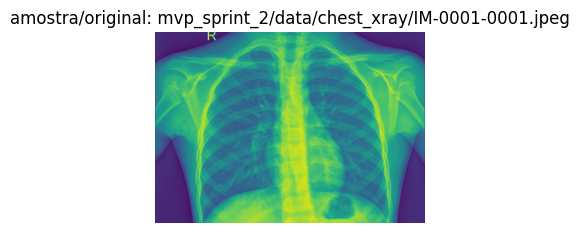

 
total de aquivos baixados de https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/train/NORMAL/: 1000

Total de arquivos baixados: 1000
Total de arquivos com falha: 0
 
https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/train/PNEUMONIA/
download: https://raw.githubusercontent.com/jardel-alves0314/analise-de-dados-puc-2023/main/mvp_sprint_2/data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


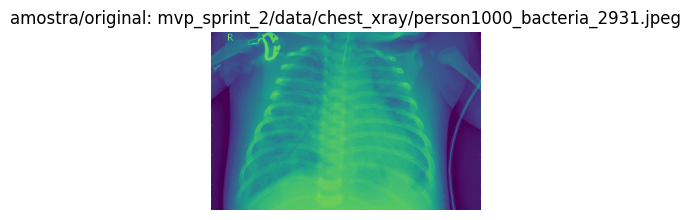

 
total de aquivos baixados de https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/train/PNEUMONIA/: 1000

Total de arquivos baixados: 1000
Total de arquivos com falha: 0
 
https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/val/NORMAL
download: https://raw.githubusercontent.com/jardel-alves0314/analise-de-dados-puc-2023/main/mvp_sprint_2/data/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


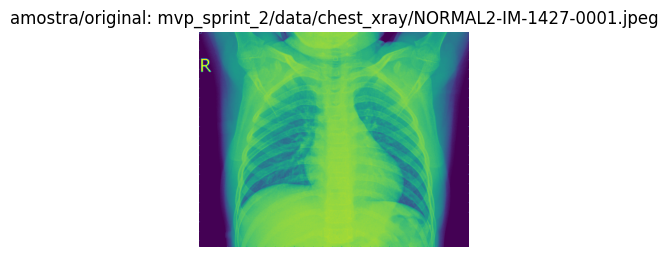

 
total de aquivos baixados de https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/val/NORMAL: 8

Total de arquivos baixados: 8
Total de arquivos com falha: 0
 
https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/val/PNEUMONIA
download: https://raw.githubusercontent.com/jardel-alves0314/analise-de-dados-puc-2023/main/mvp_sprint_2/data/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


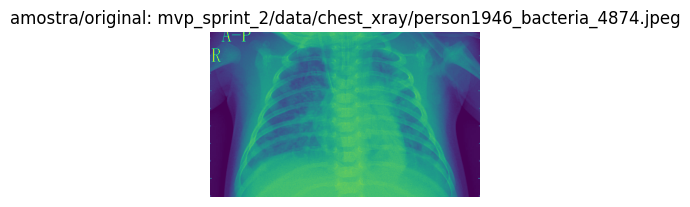

 
total de aquivos baixados de https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents/mvp_sprint_2/data/chest_xray/val/PNEUMONIA: 8

Total de arquivos baixados: 8
Total de arquivos com falha: 0
 


In [9]:
repositorio = "https://api.github.com/repos/jardel-alves0314/analise-de-dados-puc-2023/contents"

tipo    = "jpeg"
destino = "mvp_sprint_2/data/chest_xray"

url_treino_imagens_saudaveis     = f"{repositorio}/mvp_sprint_2/data/chest_xray/train/NORMAL/"
url_treino_imagens_pneumonias    = f"{repositorio}/mvp_sprint_2/data/chest_xray/train/PNEUMONIA/"

url_validacao_imagens_saudaveis  = f"{repositorio}/mvp_sprint_2/data/chest_xray/val/NORMAL"
url_validacao_imagens_pneumonias = f"{repositorio}/mvp_sprint_2/data/chest_xray/val/PNEUMONIA"

normal    = "normal"
pneumonia = "pneumonia"

# TENTA REMOVER DIRETÓRIO SE JÁ EXITIR

remover_diretorio(destino)

# TREINO / TESTE

df_saudavel  = baixar_arquivos_retornar_dataframe([url_treino_imagens_saudaveis], tipo, destino, normal, limite = 1000)
df_pneumonia = baixar_arquivos_retornar_dataframe([url_treino_imagens_pneumonias], tipo, destino, pneumonia, limite = 1000)

df_treino_teste = pd.concat([df_saudavel, df_pneumonia])


# VALIDAÇÃO

df_saudavel  = baixar_arquivos_retornar_dataframe([url_validacao_imagens_saudaveis], tipo, destino, normal, limite = 1000)
df_pneumonia = baixar_arquivos_retornar_dataframe([url_validacao_imagens_pneumonias], tipo, destino, pneumonia, limite = 1000)

df_validacao = pd.concat([df_saudavel, df_pneumonia])

refaz os índices, para eliminar as duplicidades causadas ao se concatenar os dataframes

In [10]:
df_treino_teste = df_treino_teste.reset_index(drop=True)
df_treino_teste


imagem     classe  altura  largura  canais  \
0                 IM-0001-0001.jpeg     normal    1317     1857       1   
1                 IM-0003-0001.jpeg     normal    1509     2111       1   
2                 IM-0005-0001.jpeg     normal    1837     2031       1   
3                 IM-0006-0001.jpeg     normal    1326     1663       1   
4                 IM-0007-0001.jpeg     normal    1818     2053       1   
...                             ...        ...     ...      ...     ...   
1995     person1413_virus_2422.jpeg  pneumonia     968     1136       1   
1996     person1413_virus_2423.jpeg  pneumonia    1056     1336       1   
1997  person1414_bacteria_3627.jpeg  pneumonia     704     1232       1   
1998  person1414_bacteria_3628.jpeg  pneumonia     896     1288       1   
1999     person1414_virus_2424.jpeg  pneumonia     592     1064       1   

      tamanho                       caminho  \
0      252661  mvp_sprint_2/data/chest_xray   
1      329229  mvp_sprint_2/data/chest_xray   
2      408649  mvp_sprint_2/data/chest_xray   
3      252253  mvp_sprint_2/data/chest_xray   
4      408406  mvp_sprint_2/data/chest_xray   
...       ...                           ...   
1995   137900  mvp_sprint_2/data/chest_xray   
1996   111446  mvp_sprint_2/data/chest_xray   
1997    64698  mvp_sprint_2/data/chest_xray   
1998    81420  mvp_sprint_2/data/chest_xray   
1999    45552  mvp_sprint_2/data/chest_xray   

                                                   urls  
0     https://raw.githubusercontent.com/jardel-alves...  
1     https://raw.githubusercontent.com/jardel-alves...  
2     https://raw.githubusercontent.com/jardel-alves...  
3     https://raw.githubusercontent.com/jardel-alves...  
4     https://raw.githubusercontent.com/jardel-alves...  
...                                                 ...  
1995  https://raw.githubusercontent.com/jardel-alves...  
1996  https://raw.githubusercontent.com/jardel-alves...  
1997  https://raw.githubusercontent.com/jardel-alves...  
1998  https://raw.githubusercontent.com/jardel-alves...  
1999  https://raw.githubusercontent.com/jardel-alves...  

[2000 rows x 8 columns]

refaz os índices, para eliminar as duplicidades causadas ao se concatenar os dataframes

In [11]:
df_validacao = df_validacao.reset_index(drop=True)
df_validacao


imagem     classe  altura  largura  canais  \
0       NORMAL2-IM-1427-0001.jpeg     normal    1416     1776       1   
1       NORMAL2-IM-1430-0001.jpeg     normal    1040     1272       1   
2       NORMAL2-IM-1431-0001.jpeg     normal    1416     1736       1   
3       NORMAL2-IM-1436-0001.jpeg     normal     928     1288       1   
4       NORMAL2-IM-1437-0001.jpeg     normal    1104     1240       1   
5       NORMAL2-IM-1438-0001.jpeg     normal    1104     1328       1   
6       NORMAL2-IM-1440-0001.jpeg     normal    1225     1632       1   
7       NORMAL2-IM-1442-0001.jpeg     normal    1302     1564       1   
8   person1946_bacteria_4874.jpeg  pneumonia     592      968       1   
9   person1946_bacteria_4875.jpeg  pneumonia     712     1072       1   
10  person1947_bacteria_4876.jpeg  pneumonia     664     1152       1   
11  person1949_bacteria_4880.jpeg  pneumonia     944     1416       1   
12  person1950_bacteria_4881.jpeg  pneumonia     864     1256       1   
13  person1951_bacteria_4882.jpeg  pneumonia     656     1016       1   
14  person1952_bacteria_4883.jpeg  pneumonia     952     1192       1   
15  person1954_bacteria_4886.jpeg  pneumonia    1128     1664       1   

    tamanho                       caminho  \
0    205176  mvp_sprint_2/data/chest_xray   
1    115249  mvp_sprint_2/data/chest_xray   
2    201518  mvp_sprint_2/data/chest_xray   
3    109998  mvp_sprint_2/data/chest_xray   
4     95951  mvp_sprint_2/data/chest_xray   
5    130977  mvp_sprint_2/data/chest_xray   
6    188816  mvp_sprint_2/data/chest_xray   
7    163595  mvp_sprint_2/data/chest_xray   
8     61117  mvp_sprint_2/data/chest_xray   
9     59236  mvp_sprint_2/data/chest_xray   
10    62728  mvp_sprint_2/data/chest_xray   
11    99224  mvp_sprint_2/data/chest_xray   
12    86612  mvp_sprint_2/data/chest_xray   
13    49272  mvp_sprint_2/data/chest_xray   
14    87576  mvp_sprint_2/data/chest_xray   
15   119611  mvp_sprint_2/data/chest_xray   

                                                 urls  
0   https://raw.githubusercontent.com/jardel-alves...  
1   https://raw.githubusercontent.com/jardel-alves...  
2   https://raw.githubusercontent.com/jardel-alves...  
3   https://raw.githubusercontent.com/jardel-alves...  
4   https://raw.githubusercontent.com/jardel-alves...  
5   https://raw.githubusercontent.com/jardel-alves...  
6   https://raw.githubusercontent.com/jardel-alves...  
7   https://raw.githubusercontent.com/jardel-alves...  
8   https://raw.githubusercontent.com/jardel-alves...  
9   https://raw.githubusercontent.com/jardel-alves...  
10  https://raw.githubusercontent.com/jardel-alves...  
11  https://raw.githubusercontent.com/jardel-alves...  
12  https://raw.githubusercontent.com/jardel-alves...  
13  https://raw.githubusercontent.com/jardel-alves...  
14  https://raw.githubusercontent.com/jardel-alves...  
15  https://raw.githubusercontent.com/jardel-alves...

####3.1.2.Análise da distribuição

Exibe a distribuição das classes NORMAL e PNEUMONIA que foram carregas. Foram carregadas uma quantidade igual para cada uma das classes.

normal       1000
pneumonia    1000
Name: classe, dtype: int64


<Axes: title={'center': 'pneumonias x normais - dados disponíveis'}>

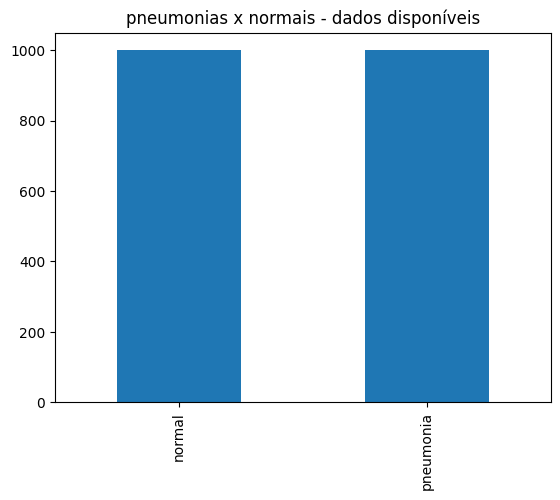

In [12]:
print((df_treino_teste['classe']).value_counts())
df_treino_teste['classe'].value_counts().plot.bar(title='pneumonias x normais - dados disponíveis')



####3.1.3.Separando Datasets de Treino e Teste

Separação dos datasets de treino e teste, na proporção de 70% para treion e 30% para teste.

Os campos dos datasets são:

- imagem: nome da imagem, uma string

- classe: classe da imagem, uma string ("NORMA.", "PNEUMONIA")

In [13]:
train, test = train_test_split(df_treino_teste[['imagem' , 'classe']] ,test_size=0.3 ,random_state=42 , shuffle=True)

print("##### Train: #####")
print(type(train))
print(train)

print("##### Test: #####")
print(type(test))
print(test)

##### Train: #####
<class 'pandas.core.frame.DataFrame'>
                             imagem     classe
836       NORMAL2-IM-0389-0001.jpeg     normal
575          IM-0660-0001-0002.jpeg     normal
557               IM-0647-0001.jpeg     normal
1235  person1112_bacteria_3053.jpeg  pneumonia
1360  person1168_bacteria_3115.jpeg  pneumonia
...                             ...        ...
1130  person1068_bacteria_3002.jpeg  pneumonia
1294  person1141_bacteria_3084.jpeg  pneumonia
860       NORMAL2-IM-0415-0001.jpeg     normal
1459  person1211_bacteria_3163.jpeg  pneumonia
1126  person1066_bacteria_3000.jpeg  pneumonia

[1400 rows x 2 columns]
##### Test: #####
<class 'pandas.core.frame.DataFrame'>
                           imagem     classe
1860   person1360_virus_2341.jpeg  pneumonia
353             IM-0485-0001.jpeg     normal
1333   person1158_virus_1940.jpeg  pneumonia
905     NORMAL2-IM-0478-0001.jpeg     normal
1289  person113_bacteria_543.jpeg  pneumonia
...                         

####3.1.4.Criando os ImageDataGenerator's

Os ImageDataGenarators, são necessários para aplicar transformações nas imagens, técnicas de augmentation.

Também são úteis para acessar as imagens originais, omitindo a criação dos tensores, outros tratamentos das imagens e  aumenta a quantidade de versões da mesma imagem.


Outra coisa bem interessante acontece com o uso dos ImageDataGenerator's: Economia de memória. Muitos processos manuais de transformação das imagens consomem muita memória do ambiente. Ao fazer as trasnformações durante o uso da imagem no treino ou na predição o custo da memória é menor.



Essas transformações incluem: rotacionamento da imagem, normalização, alteração do brilho, aplicação de zoom, espelhamento.

Parâmetros usados nos ImageDataGenators

In [14]:
path        = "mvp_sprint_2/data/chest_xray"
target_size = (300,300)
shuffle     = True
batch_size  = 32
class_mode  = "binary"
epochs      = 10



In [15]:
train_datagen=ImageDataGenerator(validation_split=0.2, #include validation split
                                 rescale = 1.0/255,
                                 preprocessing_function=orthogonal_rot,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)


Os genarators acessam os nomes das imagens no dataframe e carregam as imagens da pasta informada.

O genearator de teste foi configurado de forma diferente. Os dados não serão embaralhados e o número de batchs é igual a 1. Dessa forma é possível associar as imagens e classes aos valores preditos.

In [16]:


train_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size = target_size,
    shuffle     = shuffle,  # Embaralhar os dados
    batch_size  = batch_size,
    class_mode  = class_mode,
    x_col       = 'imagem',
    y_col       = 'classe',
    subset      = 'training' #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size = target_size,
    shuffle     = shuffle,  # Embaralhar os dados
    batch_size  = batch_size,
    class_mode  = class_mode,
    x_col       = 'imagem',
    y_col       = 'classe',
    subset      = 'validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    test ,path,
    target_size  = target_size,
    shuffle      = False,
    batch_size   = 1,
    class_mode   = class_mode,
    x_col        = 'imagem',
    y_col        = 'classe')

Found 1120 validated image filenames belonging to 2 classes.
Found 280 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


Exibindo a distribuição das classes no dataset de treino.

Dictionary: {'normal': 0, 'pneumonia': 1}
Class labels: ['normal', 'pneumonia']


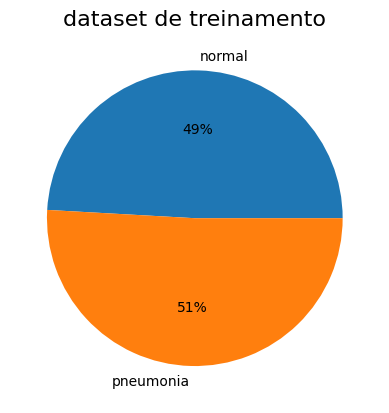

In [17]:
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))

class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

frequency = np.unique(train_generator.classes, return_counts=True)

plt.title("dataset de treinamento", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

####3.1.5.Testando a saída dos ImageDataGenerator's

O trecho de código abaixo, exibe uma imagem aleatória no dataset de treino.

É criado um novo generator que aplicas as transformações nas imagens, e cada transformação é exibida, fazendo assim uma demonstração de como o modelo será treinado em diversas situações para classificar a imagem.

O código abaixo não afeta a etapa de treino.

imagem  classe
437  IM-0543-0001.jpeg  normal

Found 1 validated image filenames belonging to 1 classes.
Batch 1:
Imagens: (1, 300, 300, 3)
Classes: (1, 1)
 


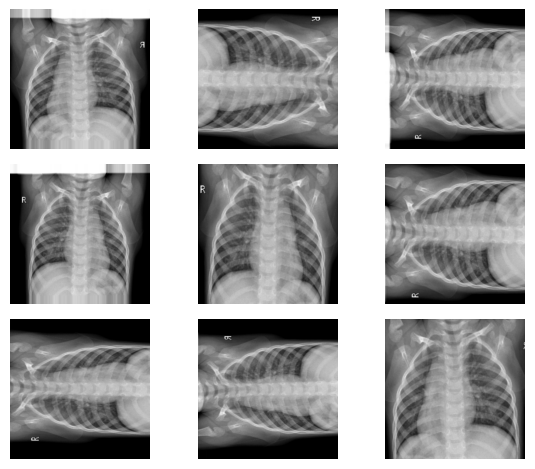

In [18]:
path = "mvp_sprint_2/data/chest_xray"
sample = train.sample(n = 1)

display(sample)

train_generator_sample = train_datagen.flow_from_dataframe(
    sample ,path,
    target_size = target_size,
    shuffle     = False,  # Embaralhar os dados
    batch_size  = 1,
    class_mode  = 'categorical', # só tem um registro
    x_col       = 'imagem',
    y_col       = 'classe',
    subset      = 'training' #training set
    )


# Iterar sobre os batches e acessar os registros correspondentes no dataframe
for i, (x_batch, y_batch) in enumerate(train_generator_sample):
    # Acessar o batch atual
    print(f"Batch {i+1}:")
    print("Imagens:", x_batch.shape)
    print("Classes:", y_batch.shape)

    print(" ")
    break


for j in range(9):
  for x_batch, y_batch in train_generator_sample:
    imagem = x_batch[0]
    plt.subplot(3, 3, j+1)
    plt.imshow(imagem)
    plt.axis('Off')
    break



plt.subplots_adjust(hspace=1.5, wspace=0.5)
plt.tight_layout()
plt.show()

###3.2.Processamento da Rede Neural

###3.2.1.Criando uma Rede Neural Convolucional - CNN

A escolha da Rede Neural Convolucional, CNN, na análise de imagens é devido à sua capacidade de extrair características relevantes e sua eficácia em uma variedade de tarefas de visão computacional.

O framework usado para isso será o TensorFlow + a api Keras.

Abaixo são criadas as várias camadas de convulução seguidas de camadas de pooling para reduzir a dimensionalidade da representação da imagem.

Conforme o modelo passa pelas camadas de convolução, são aplicados novos filtros, assim ele aprende características mais complexas.

Na sequência as camadas convolucionais são achatadas (Flatten()), isto é, são transformadas num vetor unidimensional.

As camadas de dropout ajudam a combater o overfiting do modelo, ao descartar aleatoriamente algumas entradas usadas pelo modelo.



In [19]:
model=models.Sequential()
model.add(layers.Conv2D(32 ,(3,3) , activation='relu' , input_shape=(target_size[0],target_size[1],3 ) ) )
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(64 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))



model.add(layers.Flatten() )
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 512 ,activation='relu' ))
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 1 , activation='sigmoid' ) )



model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

###3.2.1.Executando o Treinamento da Rede

Os parâmetros step_per_epoch e validation_steps não foram informados. O próprio algoritmo calculará internamente em função de outros parâmetros.

In [20]:
print("quantidade de epochs: ", epochs)
history=model.fit_generator(train_generator ,
                            epochs=epochs ,
                            validation_data=val_generator
                            )

quantidade de epochs:  10
Epoch 1/10
35/35 [==============================] - 354s 10s/step - loss: 0.6856 - accuracy: 0.5938 - val_loss: 0.5637 - val_accuracy: 0.7571
Epoch 2/10
35/35 [==============================] - 354s 10s/step - loss: 0.5392 - accuracy: 0.7196 - val_loss: 0.3819 - val_accuracy: 0.8429
Epoch 3/10
35/35 [==============================] - 345s 10s/step - loss: 0.4141 - accuracy: 0.8196 - val_loss: 0.2929 - val_accuracy: 0.8786
Epoch 4/10
35/35 [==============================] - 355s 10s/step - loss: 0.3904 - accuracy: 0.8402 - val_loss: 0.3238 - val_accuracy: 0.8714
Epoch 5/10
35/35 [==============================] - 342s 10s/step - loss: 0.3756 - accuracy: 0.8375 - val_loss: 0.2733 - val_accuracy: 0.8964
Epoch 6/10
35/35 [==============================] - 353s 10s/step - loss: 0.3484 - accuracy: 0.8705 - val_loss: 0.3390 - val_accuracy: 0.8750
Epoch 7/10
35/35 [==============================] - 341s 10s/step - loss: 0.3344 - accuracy: 0.8652 - val_loss: 0.2686 - v

###3.2.2. Acurácia x Perda

O gráfico mostra a evolução da acurácia conforme aumenta a quantidade de épocas. E o contrário aocntece com as perdas.

O treino apresenta um bom desempenho.

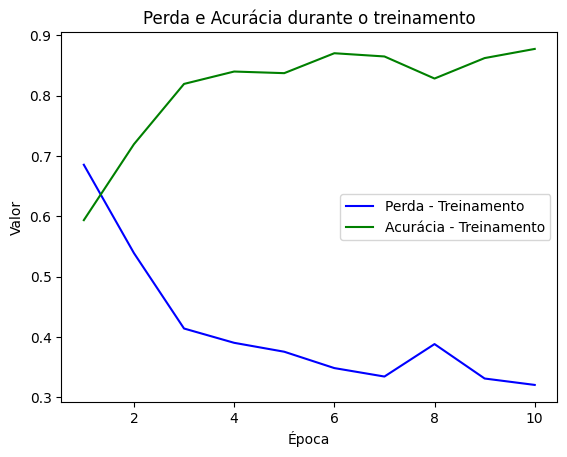

In [21]:
# Dados de perda
perda = history.history['loss']

# Dados de acurácia
acuracia = history.history['accuracy']

# Épocas
epocas = range(1, len(perda) + 1)

# Plotar gráfico combinado de perda e acurácia
plt.plot(epocas, perda, 'b', label='Perda - Treinamento')

# plt.plot(epochs, loss_val, 'r', label='Perda - Validação')
plt.plot(epocas, acuracia, 'g', label='Acurácia - Treinamento')



plt.title('Perda e Acurácia durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()

plt.show()

##4.Avaliando o modelo

In [22]:
test

imagem     classe
1860   person1360_virus_2341.jpeg  pneumonia
353             IM-0485-0001.jpeg     normal
1333   person1158_virus_1940.jpeg  pneumonia
905     NORMAL2-IM-0478-0001.jpeg     normal
1289  person113_bacteria_543.jpeg  pneumonia
...                           ...        ...
148             IM-0243-0001.jpeg     normal
1554     person124_virus_242.jpeg  pneumonia
1956   person1403_virus_2406.jpeg  pneumonia
925     NORMAL2-IM-0506-0001.jpeg     normal
942     NORMAL2-IM-0528-0001.jpeg     normal

[600 rows x 2 columns]

###**4.1.1.Avaliando o modelo**

Utilizando o dataset de teste para fazer a avalição do modelo uma acurácia muito boa, cerca de 92,67% (0.9266666769981384).

As classes do "NORMAL" e "PNEUMONIA" foram transformadas em valores binários, 0 e 1 respectivamente.

A imagem vai ser classificado em:

NORMNAL    >= 0 - <= 0.5

PNEUMONIA  >0.5 - <= 1



In [23]:
resultados = model.evaluate(test_generator)

# Exibir os resultados
print("Loss:", resultados[0])
print("Accuracy:", resultados[1])
print("")

dict_class = test_generator.class_indices
print('Dictionary: {}'.format(dict_class))
print("")

class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

600/600 [==============================] - 53s 89ms/step - loss: 0.2529 - accuracy: 0.9217
Loss: 0.2529395520687103
Accuracy: 0.92166668176651

Dictionary: {'normal': 0, 'pneumonia': 1}

Class labels: ['normal', 'pneumonia']


###**4.1.2.Executando as Predições**

Fazendo as predições do dataset de test.


In [24]:
test_generator.reset()
predictions = model.predict(test_generator, verbose = 0)

print("número de predições: ",len(predictions))

número de predições:  600


O trecho de código abaixo, percorre todas as imagens do genarator e busca a predição feita pelo modelo.


Os valores preditos e os valores originais das classes originais são armazenados em listas para gerar a matriz de confusão.

Os valores preditos são calculados da seguinte forma:

    Se a predição for maior que 0.5 então a classe predita será "PNEUMONIA", caso contrário será "NORMAL".

```
y_predito = "pneumonia" if predictions[i] > 0.5 else "normal"
```


Uma observação importante, o generator associado ao dataset de teste não foi embaralhado e possui apenas um batch. Com isso se tem um batch por imagem na mesma ordem do dataset.

0
nome da imagem:  person1360_virus_2341.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  59.55204963684082 %


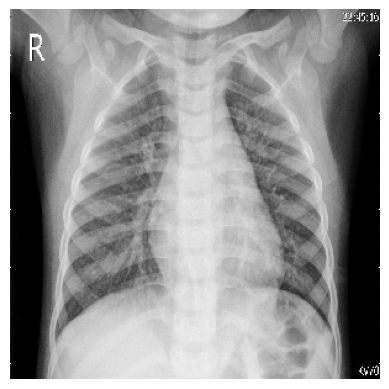

 
60
nome da imagem:  person1219_bacteria_3172.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  normal
predição:  45.68183422088623 %


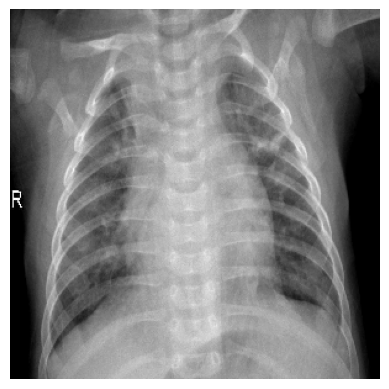

 
120
nome da imagem:  person1348_virus_2326.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  98.6054003238678 %


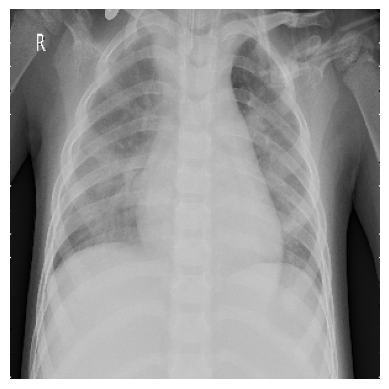

 
180
nome da imagem:  person1136_bacteria_3078.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  88.78553509712219 %


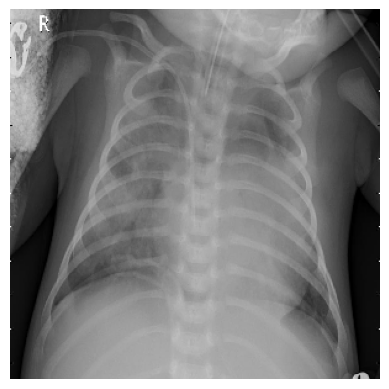

 
240
nome da imagem:  NORMAL2-IM-0267-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  pneumonia
predição:  74.87244009971619 %


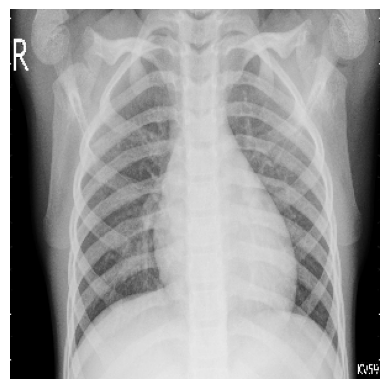

 
300
nome da imagem:  IM-0665-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  15.109387040138245 %


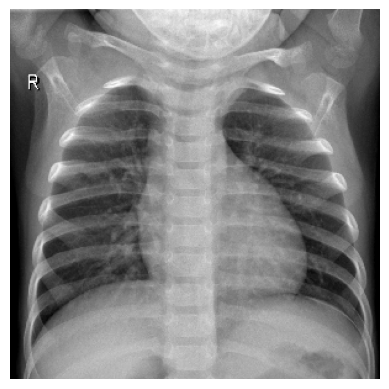

 
360
nome da imagem:  IM-0588-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  14.982597529888153 %


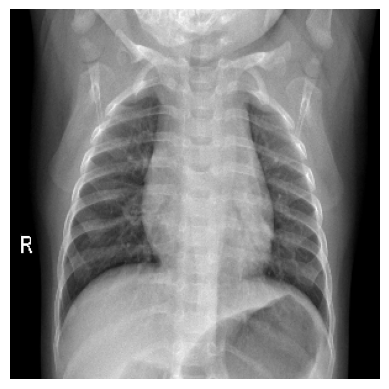

 
420
nome da imagem:  IM-0740-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  4.628139361739159 %


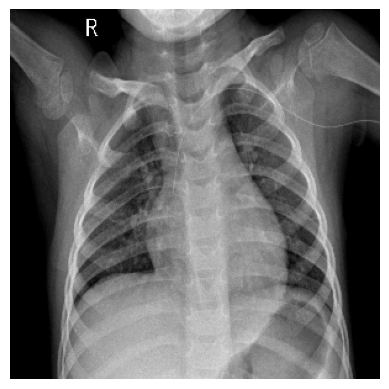

 
480
nome da imagem:  person1349_bacteria_3438.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  87.73273229598999 %


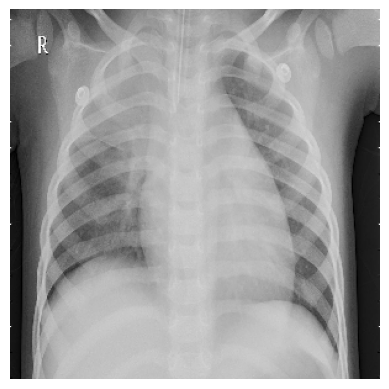

 
540
nome da imagem:  IM-0308-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  16.267038881778717 %


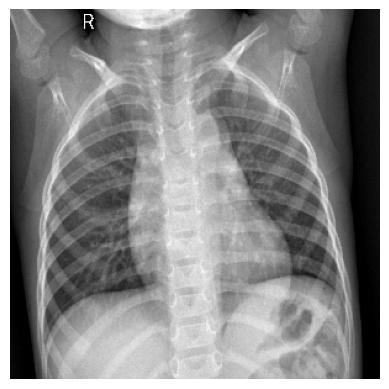

 
599
nome da imagem:  NORMAL2-IM-0528-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  14.015382528305054 %


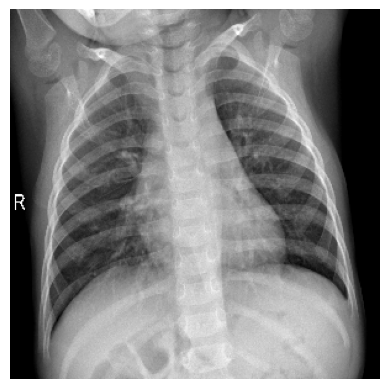

In [25]:
y_pred = list()
y_true = list()

for i in range(len(test_generator)):
  imagem, classe = test_generator[i]
  predicao = predictions[i]

  y_teste  = class_names[int(classe[0])]
  y_true.append(y_teste)

  y_predito = "pneumonia" if predictions[i] > 0.5 else "normal"
  y_pred.append(y_predito)

  # dados do dataframe
  nome_imagem   = (test.iloc[i]['imagem'])
  classe_imagem = (test.iloc[i]['classe'])

  # controle para imprimir apenas algumas imagens
  if (i % int(len(test_generator)/10) == 0) or (i == len(test_generator) - 1):
    print(i)
    print("nome da imagem: ",   nome_imagem)
    print("classe da imagem: ", classe_imagem)
    print("classe y de teste: ", y_teste, classe)
    print("classe y predito: ", y_predito)
    print("predição: ", predicao[0] * 100, "%")
    plt.imshow(imagem[0])
    plt.axis('Off')
    plt.show()
    print(" ")




###**4.1.3.Executando Outros Parâmetros de Performance**

Cálculo de outros valores de performance.

ACURACIA:  é a proporção de amostras corretamente classificadas em relação ao total de amostras.

PRECISÃO: é a proporção de verdadeiros positivos (amostras corretamente classificadas como positivas) em relação ao total de amostras classificadas como positivas.

RECALL: é a proporção de verdadeiros positivos em relação ao total de amostras positivas reais.

F1 SCORE: é uma medida que combina a precisão e o recall em um único valor.

Os resultados apurados, abaixo, indicam um modelo com um bom desempenho.

In [36]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.9216666666666666
Precision:  0.9245749459510929
Recall:  0.9216666666666666
F1 Score:  0.9215085426417454


###**4.1.4.Matriz de Confusão**

O resultado da matriz de confusão indica também um bom desempenho do modelo ao predizer as classes do dataset de teste.

DE 302 IMAGENS DE RAIO-X'S NORMAIS: 291 (96,36%) FORAM CLASSIFICADAS CORRETAMENTE E 11 (3,64%) COMO PNEUMONIAS

DE 298 IMAGENS DE RAIO-X'S DE PNEUMONIAS: 262 (87,91%) FORAM CLASSIFICADAS CORRETAMENTE E 36 (12,09%) COMO NORMAIS



Matriz de confusão sem normalização


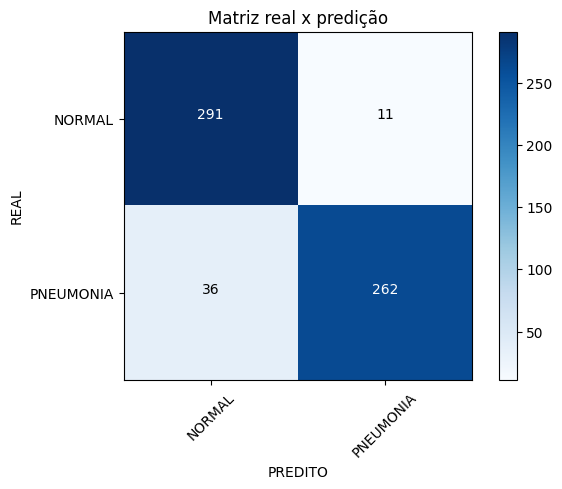

In [37]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['NORMAL',
                               'PNEUMONIA'],
                      normalize= False,
                      title='Matriz real x predição')

##**5.Exportação do modelo**

In [38]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = "mvp_sprint_2/modelos"

name_model = 'model_xray_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

Modelo salvo com o nome:  model_xray_2023-07-19T1645.h5


##**6.Usando o modelo**

###**6.1.Carregando o Modelo Salvo**

In [39]:

loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))



Modelo model_xray_2023-07-19T1645.h5 carregado com sucesso


###**6.2.Fazendo testes com o modelo salvo**

###**6.2.1.1.Executando o modelo no dataset separado para validação**

Foi separado um dataset para ser usado no final para validar o modelo gerado.

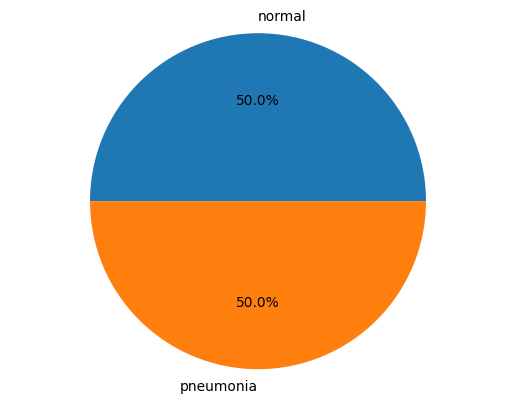

In [40]:
val = df_validacao[["imagem", "classe"]]
val


frequencias = val['classe'].value_counts()

# Plotar gráfico de pizza das frequências
plt.pie(frequencias, labels=frequencias.index, autopct='%1.1f%%')
plt.axis('equal')  # Para manter o aspecto de um círculo
plt.show()

Found 16 validated image filenames belonging to 2 classes.
16/16 [==============================] - 2s 126ms/step
0
nome da imagem:  NORMAL2-IM-1427-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  pneumonia
predição:  79.6018123626709 %


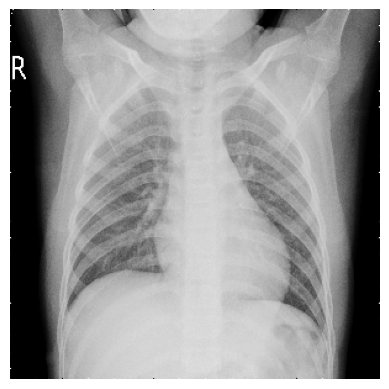

 
1
nome da imagem:  NORMAL2-IM-1430-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  22.718876600265503 %


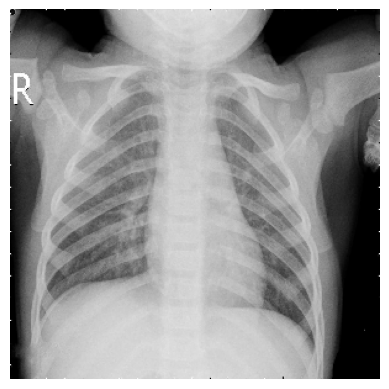

 
2
nome da imagem:  NORMAL2-IM-1431-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  pneumonia
predição:  61.1047625541687 %


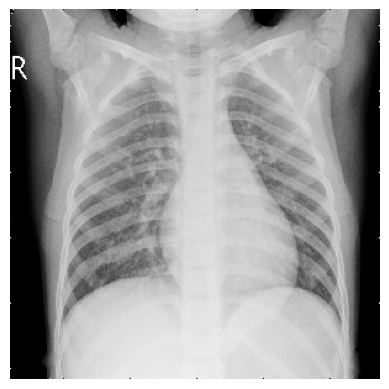

 
3
nome da imagem:  NORMAL2-IM-1436-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  45.69765627384186 %


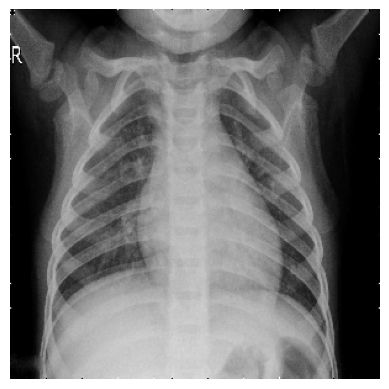

 
4
nome da imagem:  NORMAL2-IM-1437-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  pneumonia
predição:  94.80363130569458 %


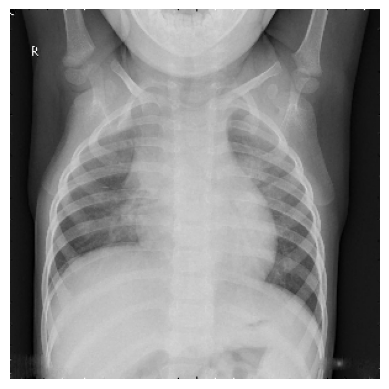

 
5
nome da imagem:  NORMAL2-IM-1438-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  pneumonia
predição:  64.27733302116394 %


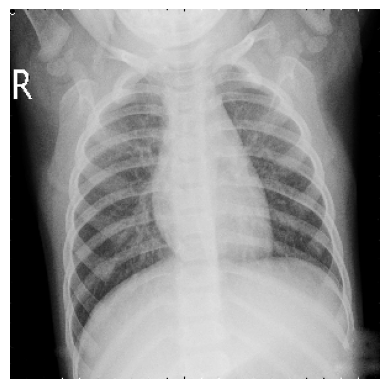

 
6
nome da imagem:  NORMAL2-IM-1440-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  7.386612892150879 %


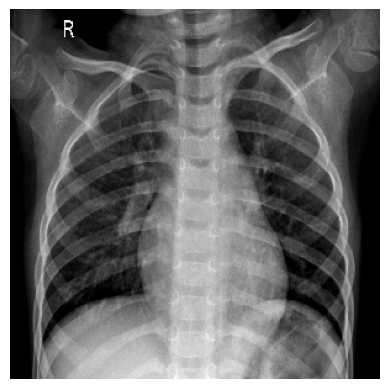

 
7
nome da imagem:  NORMAL2-IM-1442-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  4.915909096598625 %


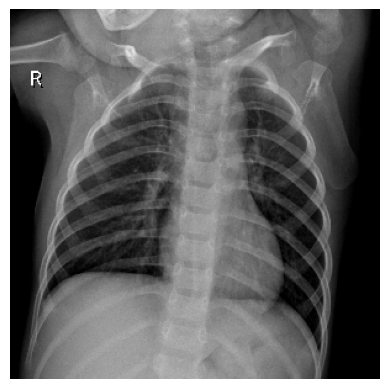

 
8
nome da imagem:  person1946_bacteria_4874.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  92.79103875160217 %


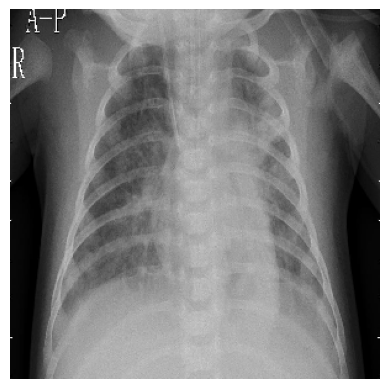

 
9
nome da imagem:  person1946_bacteria_4875.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  93.05976629257202 %


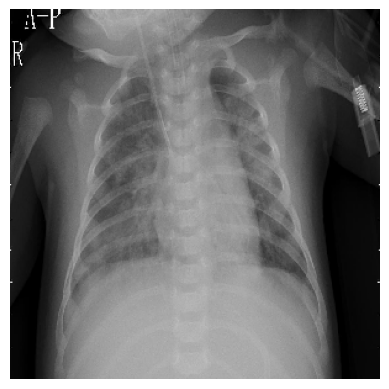

 
10
nome da imagem:  person1947_bacteria_4876.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  93.77103447914124 %


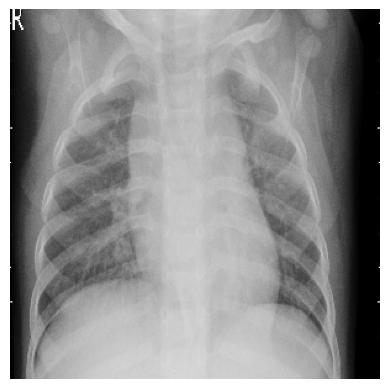

 
11
nome da imagem:  person1949_bacteria_4880.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  61.75408959388733 %


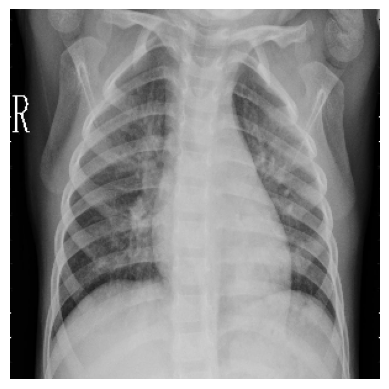

 
12
nome da imagem:  person1950_bacteria_4881.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  66.28576517105103 %


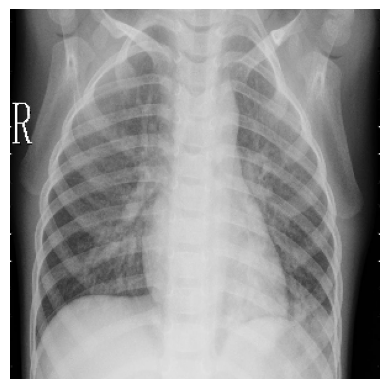

 
13
nome da imagem:  person1951_bacteria_4882.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  99.43179488182068 %


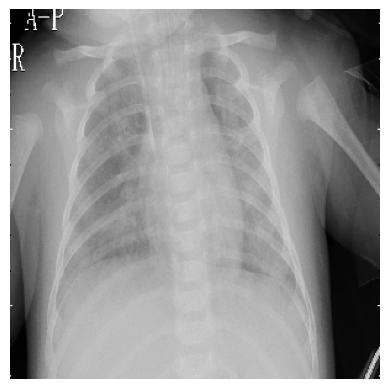

 
14
nome da imagem:  person1952_bacteria_4883.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  96.36902213096619 %


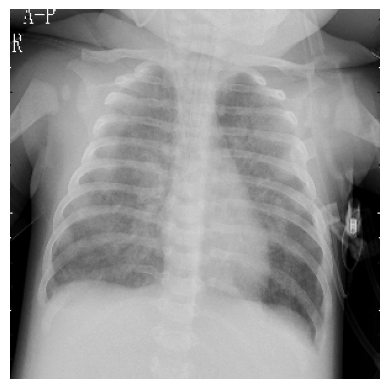

 
15
nome da imagem:  person1954_bacteria_4886.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  87.44698762893677 %


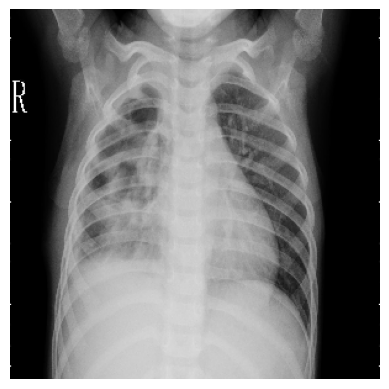

In [41]:
validacao_gen = test_datagen.flow_from_dataframe(
    val ,path,
    target_size  = target_size,
    shuffle      = False,
    batch_size   = 1,
    class_mode   = class_mode,
    x_col        = 'imagem',
    y_col        = 'classe')

predictions_val = loaded_model.predict(validacao_gen)

y_pred_val = list()
y_true_val = list()

for i in range(len(validacao_gen)):
  imagem, classe = validacao_gen[i]
  predicao = predictions_val[i]

  y_teste  = class_names[int(classe[0])]
  y_true_val.append(y_teste)

  y_predito = "pneumonia" if predictions_val[i] > 0.5 else "normal"
  y_pred_val.append(y_predito)

  # dados do dataframe
  nome_imagem   = (val.iloc[i]['imagem'])
  classe_imagem = (val.iloc[i]['classe'])

  # controle para imprimir apenas algumas imagens
  # if (i % int(len(test_generator)/10) == 0) or (i == len(test_generator) - 1):
  print(i)
  print("nome da imagem: ",   nome_imagem)
  print("classe da imagem: ", classe_imagem)
  print("classe y de teste: ", y_teste, classe)
  print("classe y predito: ", y_predito)
  print("predição: ", predicao[0] * 100, "%")
  plt.imshow(imagem[0])
  plt.axis('Off')
  plt.show()
  print(" ")

###**6.2.1.2.Matriz de Confusão**

O resultado da matriz de confusão indica também um bom desempenho do modelo ao predizer as classes do dataset de teste.





DE 8 IMAGENS DE RAIO-X'S NORMAIS: 4 (50%) FORAM CLASSIFICADAS CORRETAMENTE E 4 (50%) COMO PNEUMONIAS

DE 8 IMAGENS DE RAIO-X'S DE PNEUMONIAS: 8 (100%) FORAM CLASSIFICADAS CORRETAMENTE E 0 (0%) COMO NORMAIS


Com esses resultados, pode-se dizer que o modelo acertou 75% das vezes, não é um resultado ruim mas poderia ser melhor como nos testes anteriores.

Matriz de confusão sem normalização


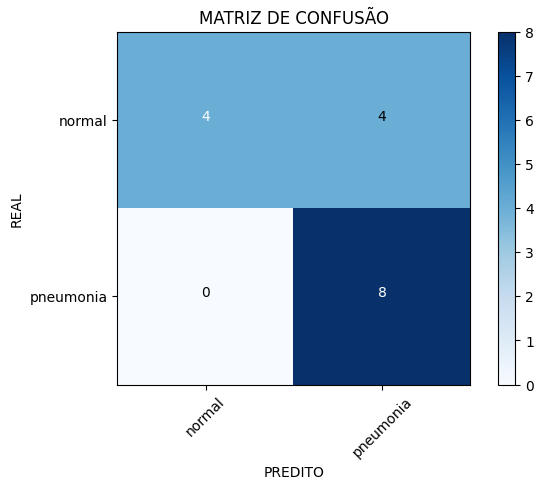

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcula a matriz de confusão
cm = confusion_matrix(y_true_val, y_pred_val)

# Cria um heatmap da matriz de confusão
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",mask =['NORMAL','PNEUMONIA'])
plot_confusion_matrix(cm, class_names,
                          normalize=False,
                          title='MATRIZ DE CONFUSÃO',
                          cmap=plt.cm.Blues)



###**6.2.2.1.Executando o modelo no dataset de teste**

600/600 [==============================] - 55s 91ms/step
número de predições:  600
0
nome da imagem:  person1360_virus_2341.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  59.55204963684082 %


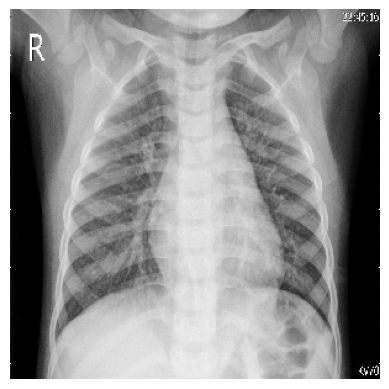

 
60
nome da imagem:  person1219_bacteria_3172.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  normal
predição:  45.68183422088623 %


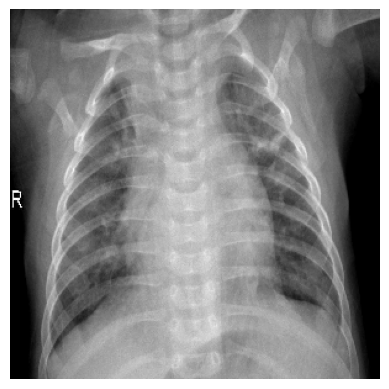

 
120
nome da imagem:  person1348_virus_2326.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  98.6054003238678 %


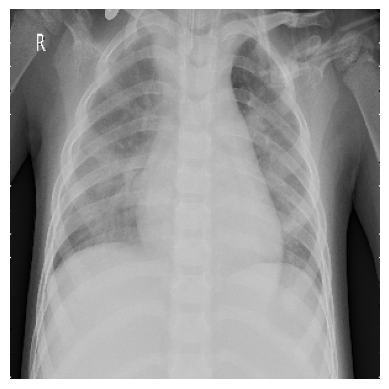

 
180
nome da imagem:  person1136_bacteria_3078.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  88.78553509712219 %


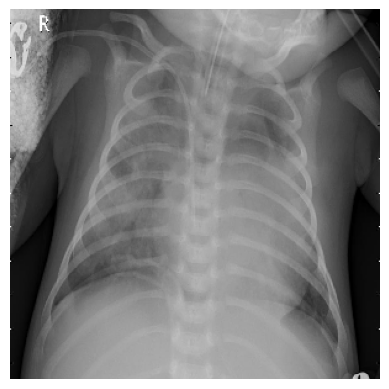

 
240
nome da imagem:  NORMAL2-IM-0267-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  pneumonia
predição:  74.87244009971619 %


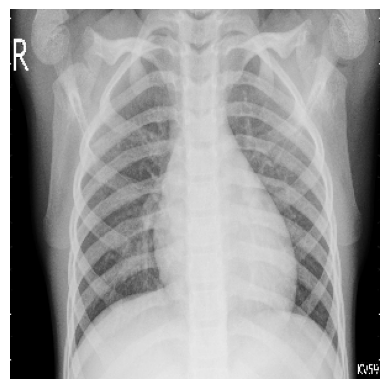

 
300
nome da imagem:  IM-0665-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  15.109387040138245 %


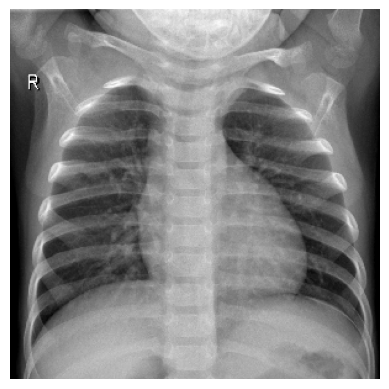

 
360
nome da imagem:  IM-0588-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  14.982597529888153 %


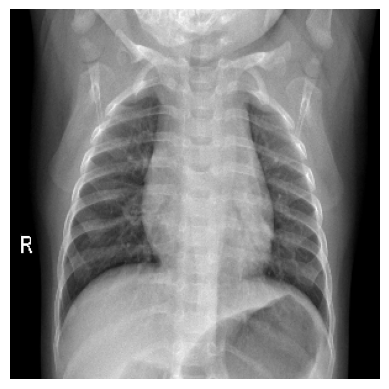

 
420
nome da imagem:  IM-0740-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  4.628139361739159 %


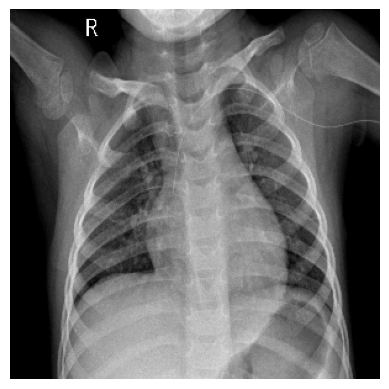

 
480
nome da imagem:  person1349_bacteria_3438.jpeg
classe da imagem:  pneumonia
classe y de teste:  pneumonia [1.]
classe y predito:  pneumonia
predição:  87.73273229598999 %


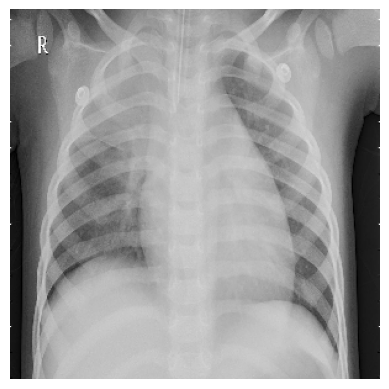

 
540
nome da imagem:  IM-0308-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  16.267038881778717 %


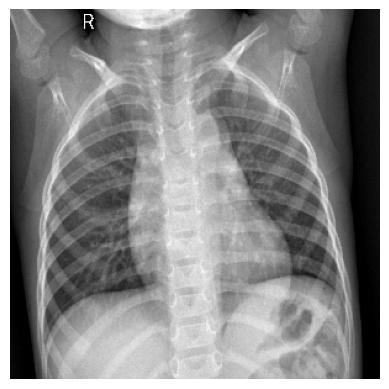

 
599
nome da imagem:  NORMAL2-IM-0528-0001.jpeg
classe da imagem:  normal
classe y de teste:  normal [0.]
classe y predito:  normal
predição:  14.015382528305054 %


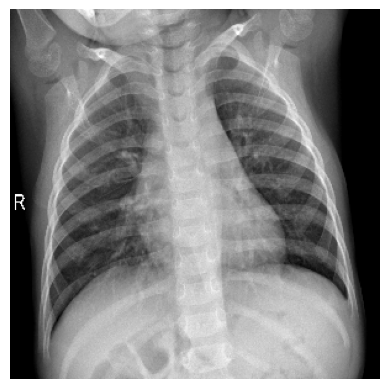

In [43]:
test_generator.reset()
predictions = loaded_model.predict(test_generator)

print("número de predições: ",len(predictions))

y_pred = list()
y_true = list()

for i in range(len(test_generator)):
  imagem, classe = test_generator[i]
  predicao = predictions[i]

  y_teste  = class_names[int(classe[0])]
  y_true.append(y_teste)

  y_predito = "pneumonia" if predictions[i] > 0.5 else "normal"
  y_pred.append(y_predito)

  # dados do dataframe
  nome_imagem   = (test.iloc[i]['imagem'])
  classe_imagem = (test.iloc[i]['classe'])

  # controle para imprimir apenas algumas imagens
  if (i % int(len(test_generator)/10) == 0) or (i == len(test_generator) - 1):
    print(i)
    print("nome da imagem: ",   nome_imagem)
    print("classe da imagem: ", classe_imagem)
    print("classe y de teste: ", y_teste, classe)
    print("classe y predito: ", y_predito)
    print("predição: ", predicao[0] * 100, "%")
    plt.imshow(imagem[0])
    plt.axis('Off')
    plt.show()
    print(" ")




###**6.2.2.2.Matriz de Confusão**

O resultado foi o mesmo da avaliação do modelo (4.1.4) .

Matriz de confusão sem normalização


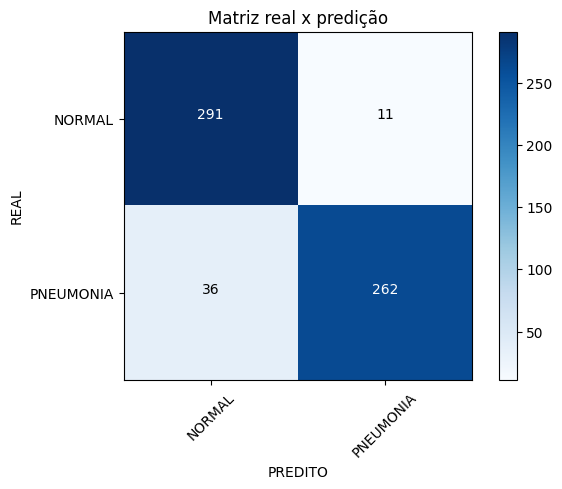

In [44]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['NORMAL',
                               'PNEUMONIA'],
                      normalize= False,
                      title='Matriz real x predição')

##**7.Conclusão**

A escolha da rede neural convolucional foi escolhida principalemte pelo seu amplo uso na identificação de imagens.

A perforamance nas etapas de treino e teste, inicialmente, foram promissoras, no entanto, depois de gerado o modelo deixou a desejar na identificação de raio-x's classificados como normais, 50% de acerto, mas obteve acerto de 100% na classificação dos raio-x's de pneumonias.

Possíveis ações para a melhoria da performance:


1.  Ter mais imagens para treino e validação, mas aumentaria o de espaço em disco
2.  Aumentar o número de épocas, mas aumentaria o tempo de processamento
3.  Aumentar a quantidade de camadas e os valores dos filtros, mas também aumentaria o tempo de processamento
4.  Incluir novas transformações, mas também aumentaria o tempo de processamento
5.  Testar outros frameworks, como o Pytorck
6.  Testar outros algoritmos






No geral, o uso da rede neural convolucional mais Tensor Flow, com mais ajustes e testes, pode alcançar um resultado satisfatório.